# Load libraries

In [5]:
# Core
import seaborn as sns
import pandas as pd
import numpy as np
from math import log,exp

# Visual
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
import graphviz


from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# EXERCICIO 1

### 1)

In [6]:
df = pd.read_csv("train.csv")

# Listing explanatory features
features = ['OverallQual', 'GrLivArea', 'GarageCars']
features_y = ['OverallQual', 'GrLivArea', 'GarageCars', 'SalePrice']

df = df[features_y]

In [7]:
## Changing the problem for a classification one

df['SalePrice'] = pd.qcut(df['SalePrice'],q = 2, labels = [-1, 1])
df.head()

,OverallQual,GrLivArea,GarageCars,SalePrice
0,7,1710,2,1
1,6,1262,2,1
2,7,1786,2,1
3,7,1717,3,-1
4,8,2198,3,1


In [8]:
## Step 1 - Computing error

def compute_error (y, y_pred, w_i):
    return (sum(w_i* (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

## Step 2 - Weights of weak classifiers 

def compute_alpha(error):
    return np.log((1-error) / error)

## Step 3 - Update weights after boosting interaction

def update_weights(w_i, alpha, y, y_pred):
    return w_i* np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))


In [9]:
## Lets now define the adaboost

# Define AdaBoost class
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M = 100):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth = 1)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):

        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred       


## The idea comes from: https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50

In [10]:
## Train test split
train, test = train_test_split(df, test_size=0.3, random_state=7)

X_train = df[:train.shape[0]]
X_test = df[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice

In [11]:
def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100
    mape = mape.round(2)
    return mape

# Predict

ab = AdaBoost()
ab.fit(X_train, y_train, M = 400)

# Predict on test set
y_pred = ab.predict(X_test)
print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred), 4))

The ROC-AUC score of the model is: 0.5084


In [12]:
## Lets check how the implementation of Scikit-Learn Adaboos would do

#ab_sk = AdaBoostClassifier(n_estimators = 400)
#ab_sk.fit(X_train, y_train)
#y_pred_sk = ab_sk.predict(X_test)
#print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred_sk), 4))

## Pretty similar, which means we are in the right path.

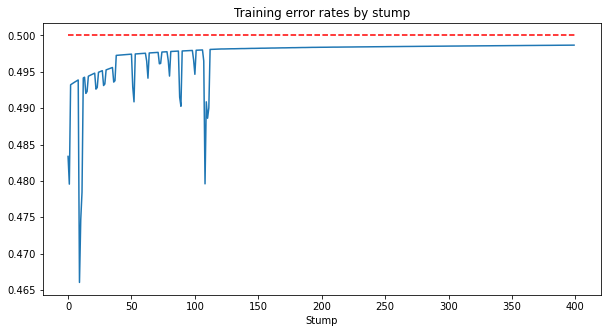

In [13]:
## Lets make now a visualization of how the estimator varies

plt.figure(figsize=(10,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

### 2) 

In [14]:
## Lets change the definition of max_depth:

class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M_dep = 1, M = 100):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M_dep: Max depth with default 1.
        M: number of boosting rounds. Default is 100 - integer
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth = M_dep)  
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):

        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred      

In [15]:
# Predict

ab = AdaBoost()
ab.fit(X_train, y_train, M_dep = 40, M = 400)

# Predict on test set
y_pred = ab.predict(X_test)
print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred), 4))

The ROC-AUC score of the model is: 0.5065


In [16]:
## Lets loop the M_dep argument so we can check which one performs better.


# EXERCICIO 2

In [17]:
df = pd.read_csv("Skyserver.csv")

In [18]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [19]:
df['class'].unique()

## The current base has a multi-level classification problem, with 3 classes.

array(['STAR', 'GALAXY', 'QSO'], dtype=object)

In [20]:
## As we are dealing with a classification problem, lets encode the Y variable. I will transfor Galaxy for 0, QSO for 1 and Star for 2. 

df = df.replace(
    {"class": {"GALAXY": 0,
              "QSO": 1,
              "STAR": 2}}                
                  )

#df['class'].unique()

<AxesSubplot:>

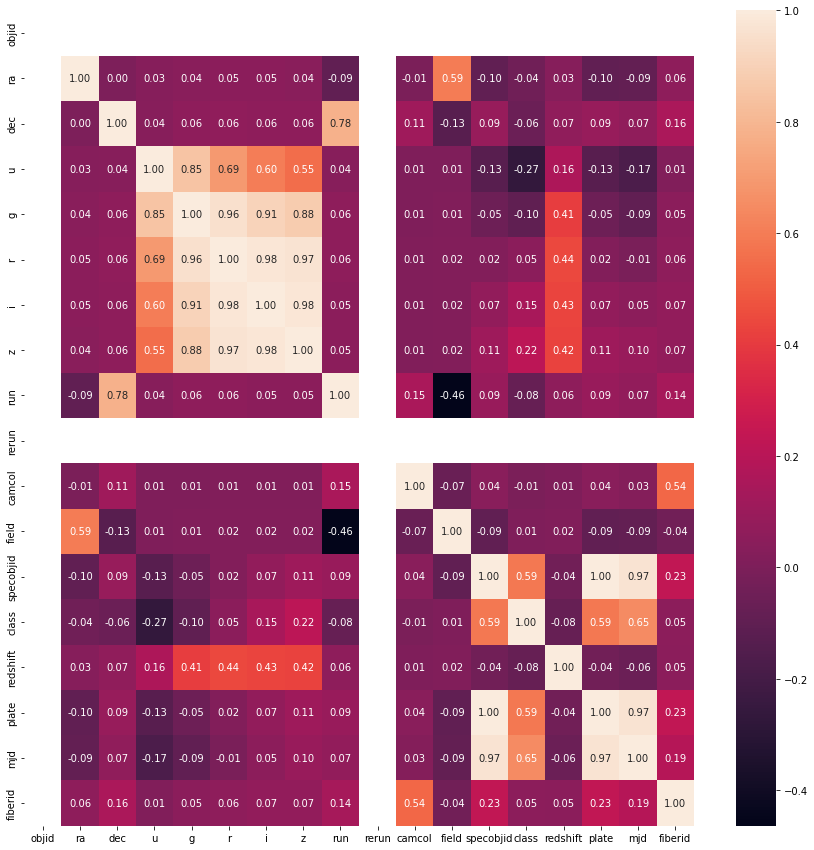

In [21]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot = True,fmt = ".2f",cbar = True)

In [22]:
#based on the explanation of the variables found on kaggle and the matrix above I decided to drop a few variables
## All the variables ID, in this sense, specobjid, fiberid, objid
## The variables run, rerun, camcol, field because that is related to where in the "Big Picture" it is looking at
## Plate, because  it does nothing to do with the classification I intend to achieve\
df.drop(['specobjid','fiberid','objid','run','rerun','camcol', 'field','plate'],axis=1,inplace=True)

#Based on https://www.kaggle.com/datasets/lucidlenn/sloan-digital-sky-survey

<AxesSubplot:>

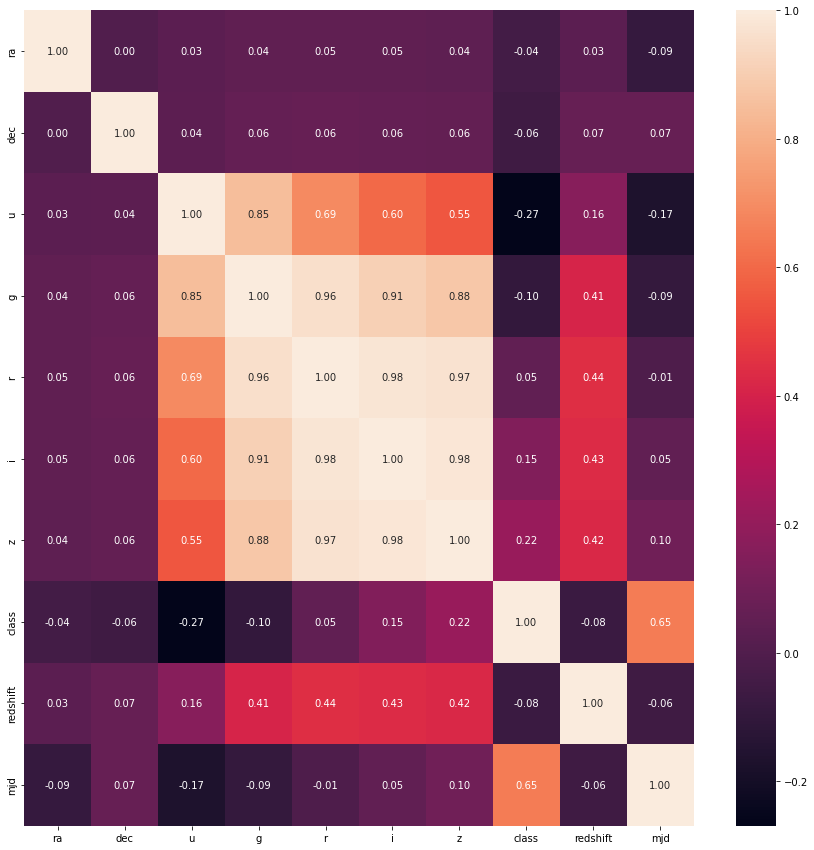

In [23]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot = True,fmt = ".2f",cbar = True)

In [24]:
## Train-test split.

train, test = train_test_split(df, test_size=0.3, random_state=7)

X_train = train.drop(['class'], axis=1)
X_test = test.drop(["class"], axis=1)
y_train = train['class']
y_test = test['class']

In [25]:
#Using Decision tree classifier because it's very good at multi-class classification 
##Finding the best parameters 
parameters_list = {'max_depth':np.arange(1,15),'min_samples_leaf':np.arange(2,10)}
all_decision_trees = GridSearchCV(DecisionTreeClassifier(random_state=7),parameters_list)
all_decision_trees.fit(X_train, y_train)

##Using the best parameters
y_pred = all_decision_trees.predict(X_test)
print(accuracy_score(y_test,y_pred))

## The accuracy score is 98%.

0.9893333333333333


[[1456   12    0]
 [  17  253    0]
 [   3    0 1259]]


<AxesSubplot:>

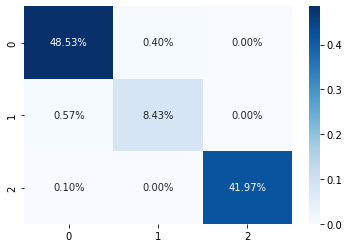

In [26]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

## The confusion matrix shows that, overall, the algorithm has a good accuracy.

In [27]:
## Lets see how the random forest performs.

#parameters_list = {'max_depth':np.arange(1,15),'min_samples_split':np.arange(2,10), 'max_features':np.arange(3,9), 'n_estimators':np.arange(100, 300)}


#all_decision_trees = GridSearchCV(RandomForestClassifier(),parameters_list)
#all_decision_trees.fit(X_train, y_train)

##Using the best parameters
#y_pred = all_decision_trees.predict(X_test)
#print(accuracy_score(y_test,y_pred))

In [28]:
parameters = {'max_depth' : [1, 3, 5],
              'n_estimators' : [100, 150, 200],
              'max_features' : [3, 6, 9],
              'min_samples_split' : [2, 4, 6]}
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=5),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
             param_grid={'max_depth': [1, 3, 5], 'max_features': [3, 6, 9],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error')

In [29]:
grid_search.best_params_

{'max_depth': 5,
 'max_features': 3,
 'min_samples_split': 2,
 'n_estimators': 150}

In [30]:
regressor_rf = RandomForestClassifier(max_depth=5, n_estimators=150, max_features=3, min_samples_split=2, random_state=4)
regressor_rf = regressor_rf.fit(X_train, y_train)
y_pred = regressor_rf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9883333333333333


[[1450    8   10]
 [  17  253    0]
 [   0    0 1262]]


<AxesSubplot:>

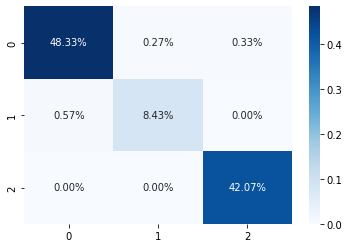

In [31]:
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

       pred     score
7  redshift  1.210253
6         z  0.011968
5         i  0.005557
8       mjd  0.003359
2         u  0.002247
3         g  0.001128
4         r  0.001128
0        ra  0.000000
1       dec  0.000000


<AxesSubplot:>

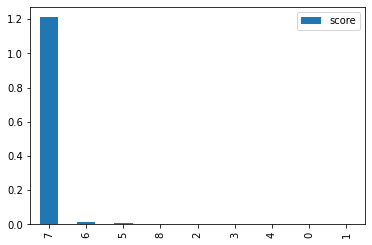

In [32]:
## Lets look at feature importance.

from sklearn.metrics import mean_squared_error
rmse_full_mod = mean_squared_error(regressor_rf.predict(X_test), y_test, squared = False)


# Initialize a list of results
results = []
# Iterate through each predictor
for predictor in X_test:
    
    # Create a copy of X_test
    X_test_copy = X_test.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    new_rmse = mean_squared_error(regressor_rf.predict(X_test_copy), y_test,
                                  squared = False)
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor,
                    'score': new_rmse - rmse_full_mod })
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                              ascending = False)

print(resultsdf)
resultsdf.plot.bar()

## redshift, i and z appear to be the most important variables.

## The feature importance was based on https://towardsdatascience.com/from-scratch-permutation-feature-importance-for-ml-interpretability-b60f7d5d1fe9

# EXERCICIO 3

In [3]:
import plotly.express as px
import time
import pandas as pd
import numpy as np

In [4]:
personnel = pd.read_csv("russia_losses_personnel.csv")
equipment = pd.read_csv("russia_losses_equipment.csv")

In [5]:
personnel.head()

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0
1,2022-02-26,3,4300,about,0
2,2022-02-27,4,4500,about,0
3,2022-02-28,5,5300,about,0
4,2022-03-01,6,5710,about,200


In [6]:
equipment.head()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles,greatest losses direction
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN,NaN


In [7]:
war = pd.merge(equipment, personnel, on=["date", "day"])
war.head()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,...,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles,greatest losses direction,personnel,personnel*,POW
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,...,2,0,NaN,NaN,NaN,NaN,NaN,2800,about,0
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,...,2,0,NaN,NaN,NaN,NaN,NaN,4300,about,0
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,...,2,0,NaN,NaN,NaN,NaN,NaN,4500,about,0
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,...,2,5,NaN,NaN,NaN,NaN,NaN,5300,about,0
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,...,2,7,NaN,NaN,NaN,NaN,NaN,5710,about,200


In [9]:
## Lets create a new variable summing the destruction of war equipments.

war["equipment_loss"] = war['aircraft'] + war['helicopter'] + war['tank'] + war['APC'] + war['field artillery'] + war['naval ship']
war

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,...,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles,greatest losses direction,personnel,personnel*,POW,equipment_loss
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,...,0,NaN,NaN,NaN,NaN,NaN,2800,about,0,664
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,...,0,NaN,NaN,NaN,NaN,NaN,4300,about,0,956
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,...,0,NaN,NaN,NaN,NaN,NaN,4500,about,0,961
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,...,5,NaN,NaN,NaN,NaN,NaN,5300,about,0,1100
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,...,7,NaN,NaN,NaN,NaN,NaN,5710,about,200,1181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2022-06-03,100,210,175,1367,3366,675,207,NaN,NaN,...,95,51.0,NaN,2329.0,121.0,Bakhmut,30950,about,498,5806
99,2022-06-04,101,210,175,1376,3379,680,207,NaN,NaN,...,95,52.0,NaN,2337.0,122.0,Zaporizhzhia,31050,about,498,5833
100,2022-06-05,102,210,175,1381,3392,686,207,NaN,NaN,...,95,53.0,NaN,2360.0,122.0,Bakhmut,31150,about,498,5857
101,2022-06-06,103,211,176,1386,3400,690,207,NaN,NaN,...,96,53.0,NaN,2395.0,125.0,Slov'yansʹk,31250,about,498,5876


In [47]:
st.set_page_config(
    page_title="Russia-Ukraine war dashboard",
    page_icon="✅",
    layout="wide",
)

# dashboard title
st.title("Russia-Ukraine war dashboard")

# top-level filters
war_index_filter = st.selectbox("Select the war day", pd.unique(war["day"]))

# dataframe filter
war = war[war["day"] == war_index_filter]


SyntaxError: invalid syntax (2277876984.py, line 16)